In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import warnings

warnings.filterwarnings("ignore")

# Start the spark context
sc = SparkContext.getOrCreate(conf=swan_spark_conf) 
print("Created Spark Context")

# create a spark session (which will run spark jobs)
spark = SparkSession.builder.getOrCreate()
print("Created Spark Session")

#  set good looking dataframes
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
print("Set Good Looking Dataframes")

# use Apache Arrow
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
print("Using Apache Arrow")

21/08/09 16:27:59 WARN Utils: Your hostname, KAGE-LAPTOP resolves to a loopback address: 127.0.1.1; using 172.19.177.133 instead (on interface eth0)
21/08/09 16:27:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/09 16:28:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
INFO:SparkMonitorKernel:Client Connected ('127.0.0.1', 43938)


Created Spark Context
Created Spark Session
Set Good Looking Dataframes
Using Apache Arrow


In [2]:
sdfWeekdays = spark.read.parquet('./preprocessed_data/weekdayRemovedInvalids.parquet')
sdfWeekends = spark.read.parquet('./preprocessed_data/weekendsRemovedInvalids.parquet')
sdfZoneLookup = spark.read.csv('./raw_data/taxi_zone_lookup.csv', header=True)

In [3]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import DataFrame as D

ints = ['LocationID']
strings = ('Borough', 'Zone', 'service_zone')
dtypes = {column: IntegerType() for column in ints}
dtypes.update({column: StringType() for column in strings})

setSchema = StructType()
for column in sdfZoneLookup.columns:
    setSchema.add(column,
                  dtypes[column],
                  True)
    
sdfZoneLookup = spark.read.csv('./raw_data/taxi_zone_lookup.csv', header=True, schema=setSchema)

In [4]:
print(sdfZoneLookup.select('LocationID').distinct().count())

#There are 265 LocationIDs but the data dictionary tells us there should only be 263

print(sdfZoneLookup.orderBy('LocationID').tail(5))

#On closer inspection, zones 264 and 265 seem to be invalid -> We drop them

sdfZoneLookup = sdfZoneLookup.filter(sdfZoneLookup.LocationID.isin(list(range(1,264))))

265
[Row(LocationID=261, Borough='Manhattan', Zone='World Trade Center', service_zone='Yellow Zone'), Row(LocationID=262, Borough='Manhattan', Zone='Yorkville East', service_zone='Yellow Zone'), Row(LocationID=263, Borough='Manhattan', Zone='Yorkville West', service_zone='Yellow Zone'), Row(LocationID=264, Borough='Unknown', Zone='NV', service_zone='N/A'), Row(LocationID=265, Borough='Unknown', Zone='NA', service_zone='N/A')]


In [233]:
def zoneExpectedEarnings(sdf, weekend):
    sdfZoneDailyPU = sdf.groupBy("PUDate", "PULocationID").count()
    sdfZoneAvgDailyPU = sdfZoneDailyPU.groupBy("PULocationID").sum("count")
    if (weekend):
        sdfZoneAvgDailyPU = sdfZoneAvgDailyPU.withColumn("AvgDailyPU", sdfZoneAvgDailyPU['sum(count)'] / 40.0) \
        .drop("sum(count)")
    else:
        sdfZoneAvgDailyPU = sdfZoneAvgDailyPU.withColumn("AvgDailyPU", sdfZoneAvgDailyPU['sum(count)'] / 52.0) \
        .drop("sum(count)")
    
    sdfZoneDailyAvg = sdf.groupBy("PUDate","PULocationID").avg('total_amount')
    sdfZoneAvgDailyTot = sdfZoneDailyAvg.groupBy("PULocationID").sum("avg(total_amount)")
    if (weekend):
        sdfZoneAvgDailyTot = sdfZoneAvgDailyTot.withColumn("ExpectedDailyAvg", 
                                                           sdfZoneAvgDailyTot["sum(avg(total_amount))"] / 40.0) \
        .drop("sum(avg(total_amount))")
    else:
        sdfZoneAvgDailyTot = sdfZoneAvgDailyTot.withColumn("ExpectedDailyAvg", 
                                                           sdfZoneAvgDailyTot["sum(avg(total_amount))"] / 52.0) \
        .drop("sum(avg(total_amount))")
    
    
    sdfExpEarnings = sdfZoneAvgDailyTot.join(sdfZoneAvgDailyPU, 
                                             sdfZoneAvgDailyTot.PULocationID == sdfZoneAvgDailyPU.PULocationID, 
                                             "inner") \
    .drop(sdfZoneAvgDailyPU.PULocationID)
    
    sdfExpEarnings = sdfExpEarnings.withColumn("ExpectedEarnings",
                                                sdfExpEarnings.ExpectedDailyAvg * sdfExpEarnings.AvgDailyPU)\
    .drop("AvgDailyPU")\
    .drop("ExpectedDailyAvg")
    
    sdfExpEarnings = sdfExpEarnings.join(sdfZoneLookup, 
                                         sdfZoneLookup.LocationID == sdfExpEarnings.PULocationID, 
                                         "inner") \
    .drop("Zone") \
    .drop("service_zone") \
    .drop("LocationID")
    
    sdfExpEarnings = sdfExpEarnings.withColumn("logEE", F.log(sdfExpEarnings.ExpectedEarnings))
    
    return sdfExpEarnings

dfWDExpEarnings = zoneExpectedEarnings(sdfWeekdays, False).toPandas()
dfWEExpEarnings = zoneExpectedEarnings(sdfWeekends, True).toPandas()

255

In [224]:
import geopandas as gpd
import pandas as pd
import folium

sf = gpd.read_file("./raw_data/taxi_zones/taxi_zones.shp")
pdZoneLookup = sdfZoneLookup.toPandas()

# Following line of code taken from Lab 2 of MAST30034 and converts the shapefile boundaries to coordinates
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [225]:
gdf = gpd.GeoDataFrame(pd.merge(dfWDExpEarnings, sf, left_on='PULocationID', right_on='LocationID')).drop('LocationID',axis=1)
WDGeoJSON = gdf[['PULocationID','geometry']].drop_duplicates('PULocationID').to_json()

In [226]:
m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on how to plot aggregated data.
m.add_child(folium.Choropleth(geo_data= WDGeoJSON, 
                              data= dfWDExpEarnings,
                              columns=['PULocationID', 'logEE'],
                              key_on='feature.properties.PULocationID', 
                              threshold_scale = [-6, -1, 4, 7, 10, 13],
                              fill_color = 'YlGnBu'))

m.save('./plots/weekdaysEEMap.html')

In [227]:
gdf2 = gpd.GeoDataFrame(pd.merge(dfWEExpEarnings, sf, left_on='PULocationID', right_on='LocationID')).drop('LocationID',axis=1)
WEGeoJSON = gdf2[['PULocationID','geometry']].drop_duplicates('PULocationID').to_json()

m2 = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on how to plot aggregated data.
m2.add_child(folium.Choropleth(geo_data= WEGeoJSON, 
                              data= dfWEExpEarnings,
                              columns=['PULocationID', 'logEE'],
                              key_on='feature.properties.PULocationID',
                              threshold_scale = [-6, -1, 4, 7, 10, 13],
                              fill_color = 'YlGnBu'))

m2.save('./plots/weekendsEEMap.html')

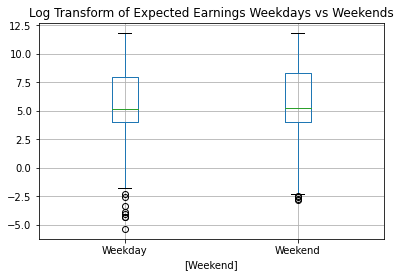

In [228]:
from matplotlib import *

dfWDExpEarnings['Weekend'] = 'Weekday'
dfWEExpEarnings['Weekend'] = 'Weekend'

concatEE = pd.concat([dfWDExpEarnings, dfWEExpEarnings])

bxplt = concatEE[['logEE', 'Weekend']].boxplot(by="Weekend")
bxplt.set_title("Log Transform of Expected Earnings Weekdays vs Weekends")
bxplt.get_figure().suptitle('')

pyplot.savefig("./plots/logEE.jpg", bbox_inches = 'tight')